## Dataset

As a result of the many interpretations of what constitutes hate speech, I followed the United Nation's [definition](https://www.un.org/en/hate-speech/understanding-hate-speech/what-is-hate-speech) outlined below:

Hate speech is *“any kind of communication in speech, writing or behaviour, that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor.”*

The data used for this project was sourced from two datasets which closely aligned with this definition of hate speech. The first dataset was obtained from the *Automated Hate Speech Detection and the Problem of Offensive Language* study by Thomas Davidson et al (Github repository [here](https://github.com/t-davidson/hate-speech-and-offensive-language)). The automated hate speech detection dataset consists of more than 25K tweets categorized as hate speech, offensive language or neither, with tweets with racist and homophobic connotations being more likely to be classified as hate speech and sexist comments as offensive language.

The first dataset is summarized below:

| Column Name | Description |
|-|-|
| count | number of CrowdFlower (CF) users who coded each tweet (minimum is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF)|
| hate_speech | number of CF users who judged the tweet to be hate speech|
| offensive_language | number of CF users who judged the tweet to be offensive.|
| neither |number of CF users who judged the tweet to be neither offensive nor non-offensive.|
| class  | class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither |

For the scope of this project, only the `class` column will be used. The `class` column contains 1430, 4163, and 19190 tweets classified as hate speech, offensive language and neither respectively. The hate speech class is augmented with more tweets from a second dataset to make up for the underrepresentation of the class.

The second dataset, the *measuring hate speech* dataset, was sourced from the UC Berkeley D-lab (dataset link [here](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech)). According to this [paper](https://), this dataset adopts the legal definition of hate speech in the US and uses this for classifying hate speech. It consists of several columns, but we are most interested in the `hatespeech` column, which contains 3 classes - 0, 1, and 2. 2 is assigned to the most hateful tweets and 0 is neutral (but not necessarily harmless/inoffensive).

The final dataset is of the structure below:

| Column Name | Description |
|-|-|
| Sentiment | Contains 3 sentiment labels: hate, offensive & normal |
| Text | Contains the tweets |

**WARNING: From this point onwards features offensive language**




In [24]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import re
from collections import Counter
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from datasets import Dataset

## Data Preprocessing
Key:

Dataset 1: automated-hate-speech-detection.csv
*   0 - Hate Speech
*   1 - Offensive
*   2 - Neither

Dataset 2: measuring-hate-speech.parquet
*   2.0 - Hate Speech
*   1.0 - Neutral, ambigious, approximately hate speech
*   0.0 - Not hate speech










In [6]:
dataset_2 = pd.read_parquet("measuring-hate-speech.parquet")

# Selecting required columns
df_2 = dataset_2[["hatespeech", "text"]]
df_2

,hatespeech,text
0,0.0,Yes indeed. She sort of reminds me of the elde...
1,0.0,The trans women reading this tweet right now i...
2,2.0,Question: These 4 broads who criticize America...
3,0.0,It is about time for all illegals to go back t...
4,2.0,For starters bend over the one in pink and kic...
...,...,...
135551,0.0,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...
135552,0.0,Millions of #Yemen-is participated in mass ral...
135553,0.0,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...
135554,0.0,Millions of #Yemen-is participated in mass ral...


In [7]:
# Viewing count of each class label
df_2["hatespeech"].value_counts()

,count
hatespeech,
0.0,80624
2.0,46021
1.0,8911


In [8]:
# Selecting only hate speech rows with values of 2.0
df_2 = df_2[(df_2["hatespeech"] == 2.0)]

# Resetting the index of the new df
df_2.reset_index(drop=True, inplace=True)

# Checking number of rows in df
print(f'Number of rows: {len(df_2)}')

# Changing the name of the hate speech column and the label
# to match the main dataset (automated-hate-speech-detection.csv)

df_2 = df_2.rename(columns={"hatespeech": "class"})
df_2["class"] = df_2["class"].replace({2.0: 0})

# Converting datatype
df_2["class"] = df_2["class"].astype(int)
print(df_2.head())

Number of rows: 46021
   class                                               text
0      0  Question: These 4 broads who criticize America...
1      0  For starters bend over the one in pink and kic...
2      0  Who the fuck is this insignificant simple mind...
3      0         Fuck off you insufferable retarded faggot.
4      0  Worthless whore, these tits with look nice wit...


In [9]:
# View summary of the df
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46021 entries, 0 to 46020
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   46021 non-null  int64 
 1   text    46021 non-null  object
dtypes: int64(1), object(1)
memory usage: 719.2+ KB


In [10]:
# Check for duplicates
print(f'Number of duplicates: {df_2.duplicated().sum()}')

# Dropping duplicates
df_2 = df_2.drop_duplicates()
df_2.reset_index(drop=True, inplace=True)
df_2.info()

Number of duplicates: 31109
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14912 entries, 0 to 14911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   14912 non-null  int64 
 1   text    14912 non-null  object
dtypes: int64(1), object(1)
memory usage: 233.1+ KB


In [11]:
df_2['class'].value_counts()

,count
class,
0,14912


In [12]:
# Reading main dataset
dataset_1 = pd.read_csv("automated-hate-speech-detection.csv")
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
# Checking for duplicates
dataset_1.duplicated().sum()

0

In [13]:
# Checking the value counts of class labels
dataset_1["class"].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [15]:
# Dropping unnecessary rows
df_1 = dataset_1.drop(columns=["Unnamed: 0", "count", "hate_speech", "offensive_language", "neither"])

# Renaming columns
df_1 = df_1.rename(columns={"tweet": "text"})

# Concatenating df and df2 while shuffling the values
df_1 = pd.concat([df_1, df_2]).sample(frac=1).reset_index(drop=True)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39695 entries, 0 to 39694
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   39695 non-null  int64 
 1   text    39695 non-null  object
dtypes: int64(1), object(1)
memory usage: 620.4+ KB


In [16]:
df_1.value_counts("class")

,count
class,
1,19190
0,16342
2,4163


In [17]:
# Replacing the labels of the classes in "class" column to "hate","offensive" or "normal"
df_1["class"] = df_1["class"].replace({0: "hate", 1: "offensive", 2: "normal"})

# Renaming class
df_1 = df_1.rename(columns={"class": "sentiment"})
df_1.head()

,sentiment,text
0,offensive,RT @PRAYINGFORHEAD: mmy nigga flavio said deuc...
1,hate,"@IsraelUSAforevr @Colleen20238198 Well, defini..."
2,hate,10% of stupids from each religions thinks that...
3,hate,@Kenyankop @PillowPrincesse @wanza_ Hope you k...
4,offensive,RT @StonerBoii2cold: I just wanna be drunk on ...


In [19]:
# Cleaning the data
def clean(text):
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing the word `rt`
    text = re.sub('(RT)', '', text)
    # removing the word `url`
    text = re.sub('(URL)', '', text)
    # removing urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # removing numbers and unwanted characters
    text = re.sub(r'[0-9]+|&#[0-9]+;', '', text)
    return text

df_1["cleaned_text"] = df_1["text"].apply(clean)
df_1

,sentiment,text,cleaned_text
0,offensive,RT @PRAYINGFORHEAD: mmy nigga flavio said deuc...,mmy nigga flavio said deuces hoe
1,hate,"@IsraelUSAforevr @Colleen20238198 Well, defini...","Well, definitely the worst Tranny. Hey Joe, ..."
2,hate,10% of stupids from each religions thinks that...,% of stupids from each religions thinks that t...
3,hate,@Kenyankop @PillowPrincesse @wanza_ Hope you k...,"Hope you know if you believe in hell, that ..."
4,offensive,RT @StonerBoii2cold: I just wanna be drunk on ...,I just wanna be drunk on stage going ham in ...
...,...,...,...
39690,hate,Finest Nigga on the block and he still ain't w...,Finest Nigga on the block and he still ain't w...
39691,hate,Massive troops of armed national guards should...,Massive troops of armed national guards should...
39692,hate,We must remove this cancer that the USA and Br...,We must remove this cancer that the USA and Br...
39693,hate,This is for rachel you big fat white nasty sme...,This is for rachel you big fat white nasty sme...


In [20]:
# Checking for empty rows
df_1[df_1["text"] == ""]

,sentiment,text,cleaned_text


In [21]:
# Saving new dataset
df_1.to_csv("hatespeech_combined.csv", index=False)

In [22]:
df = pd.read_csv("hatespeech_combined.csv")
df.head()

,sentiment,text,cleaned_text
0,offensive,RT @PRAYINGFORHEAD: mmy nigga flavio said deuc...,mmy nigga flavio said deuces hoe
1,hate,"@IsraelUSAforevr @Colleen20238198 Well, defini...","Well, definitely the worst Tranny. Hey Joe, ..."
2,hate,10% of stupids from each religions thinks that...,% of stupids from each religions thinks that t...
3,hate,@Kenyankop @PillowPrincesse @wanza_ Hope you k...,"Hope you know if you believe in hell, that ..."
4,offensive,RT @StonerBoii2cold: I just wanna be drunk on ...,I just wanna be drunk on stage going ham in ...


## Exploratory Data Analysis

<ipython-input-25-edfa5725db84>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df['sentiment'].value_counts(), palette='icefire')


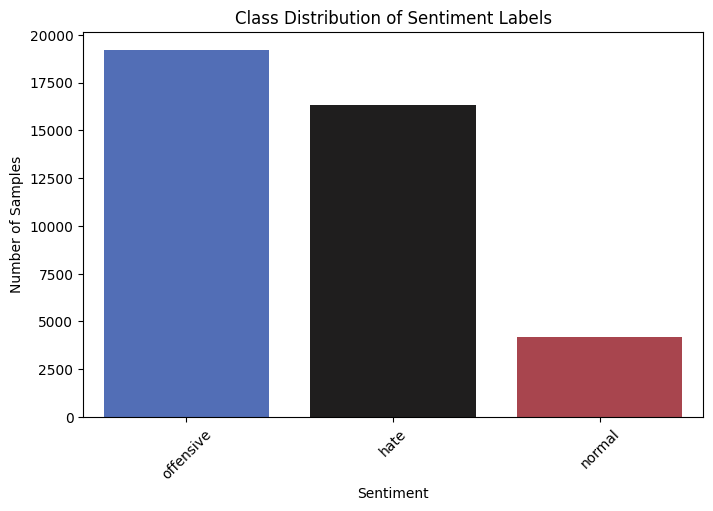

In [ ]:
# Plotting a bar chart to show the distribution of each sentiment class
plt.figure(figsize=(8, 5))
sns.barplot(data=df['sentiment'].value_counts(), palette='icefire')
plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Function to generate word cloud
def word_cloud(df, sentiment):
    # Filtering the DataFrame for rows with the specified sentiment label
    sentiment_text = df[df['sentiment'] == sentiment]['cleaned_text'].values

    # Joining all the filtered text into one large string
    combined_text = ' '.join(sentiment_text)

    # Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {sentiment.capitalize()} Tweets')
    plt.show()

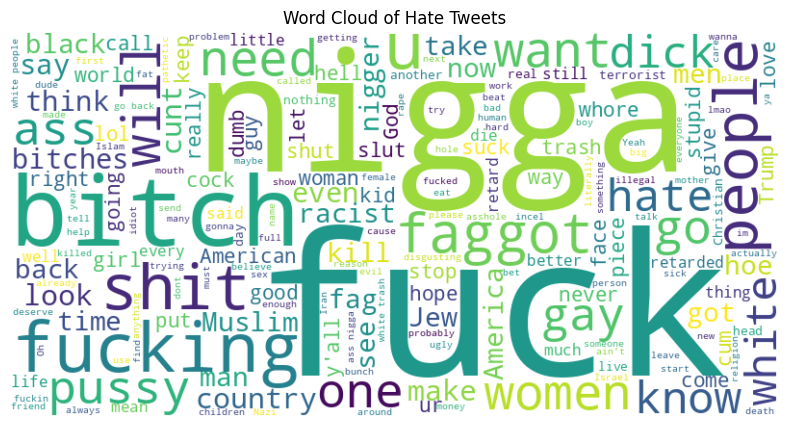

In [ ]:
word_cloud(df, 'hate')

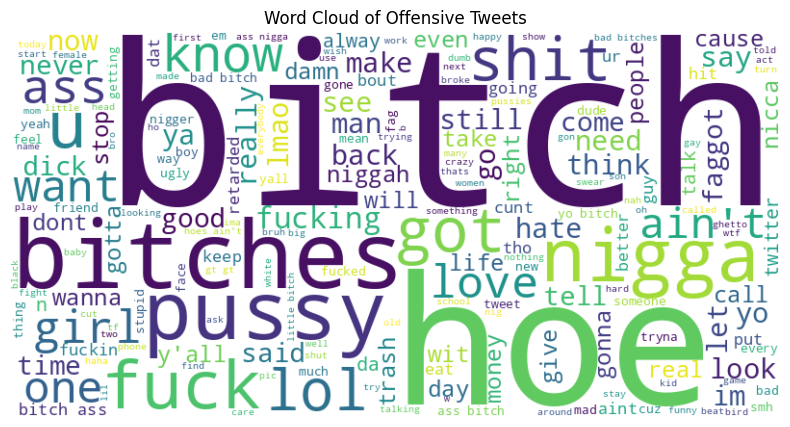

In [ ]:
word_cloud(df, 'offensive')

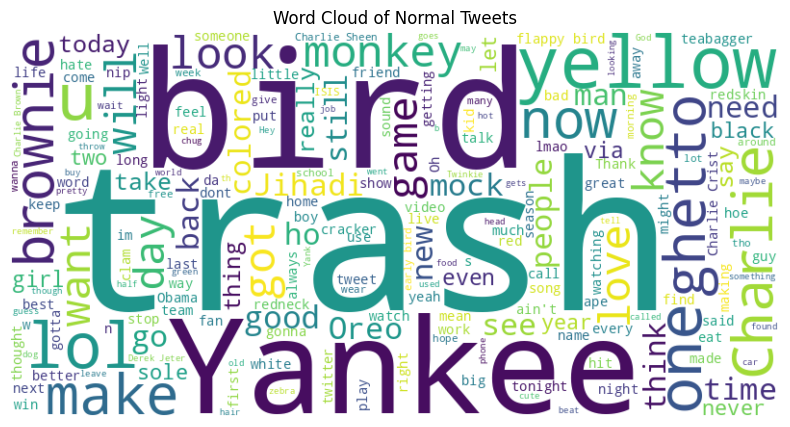

In [ ]:
word_cloud(df, 'normal')

In [ ]:
# Download stopwords from nltk library
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

# Function for plotting the top n words in each sentiment class
def plot_top_n_words(df, sentiment, n=None):

    # Join all the text for the specified sentiment and split into words
    words = ' '.join(df[df['sentiment'] == sentiment]['cleaned_text']).split()

    # Filter out stopwords and punctuation
    filtered_words = [re.sub(r'[^\w\s]', '', word)
    for word in words if word.lower() not in stopword]

    # Remove any empty strings
    filtered_words = [word for word in filtered_words if word]

    # Count the occurrences of the remaining words
    common_words = Counter(filtered_words).most_common(n)
    words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

    # Plot bar graphs
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')
    plt.title(f'Top {n} Most Common Words in Tweets Labelled as "{sentiment.capitalize()}"')
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<ipython-input-30-bd6e902bc95a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')


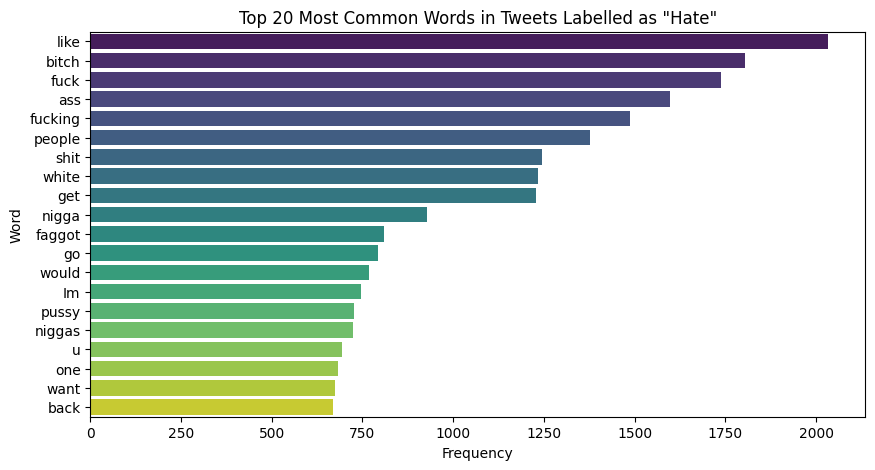

<ipython-input-30-bd6e902bc95a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')


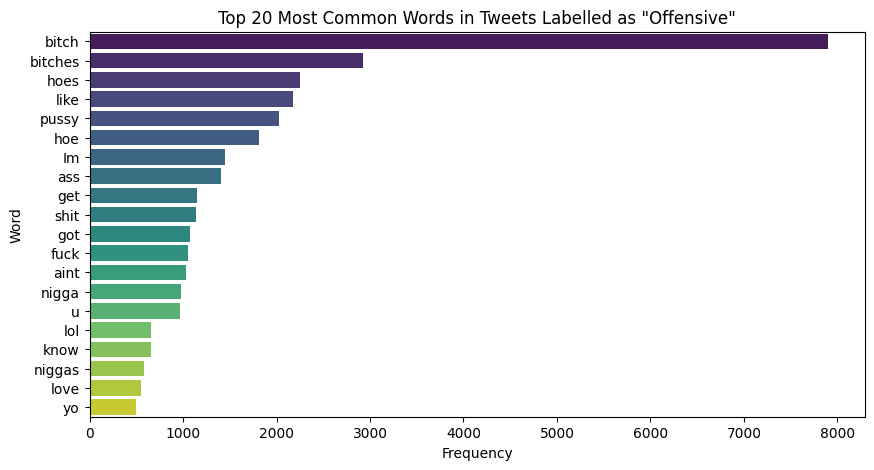

<ipython-input-30-bd6e902bc95a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')


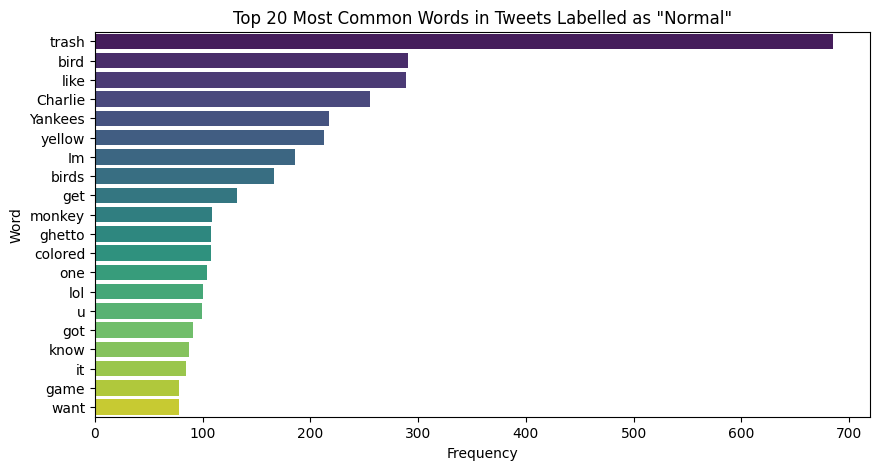

In [ ]:
plot_top_n_words(df, 'hate', n=20)
plot_top_n_words(df, 'offensive', n=20)
plot_top_n_words(df, 'normal', n=20)

Ironically, the most used word among hate tweets is "like". However, upon inspection of the dataset, this was found to mostly consist of word used as a filler word and as a synonym of "as if".

The graph of normal tweets do not contain any profanity as they are, however, the words "monkey" and "colored" were both used in several offensive contexts.The name "Charlie" was usually used to reference celebrities and people bearing the name (i.e. Charlie Puth, Charlie Sheen etc.), the cartoon character "Charlie Brown", and as a British slang for a "silly person".